# NYC Electric Savings Initiative-Membership Predictions  

Electric companies in the NYC area are looking to reduce electric loads during the peak times of the year. History has shown us that exhausting the electric grid can lead to outages, fatalaties, and financial losses. One of methods to reduce electric usage is by incentivizing the customers that use significantly more usage than their normal times. Ultimately, this will allow us to determine the # of customers who will participate in the summer energy reduction program for 2020 and help build a financial model to sustain the electric infrastructure.

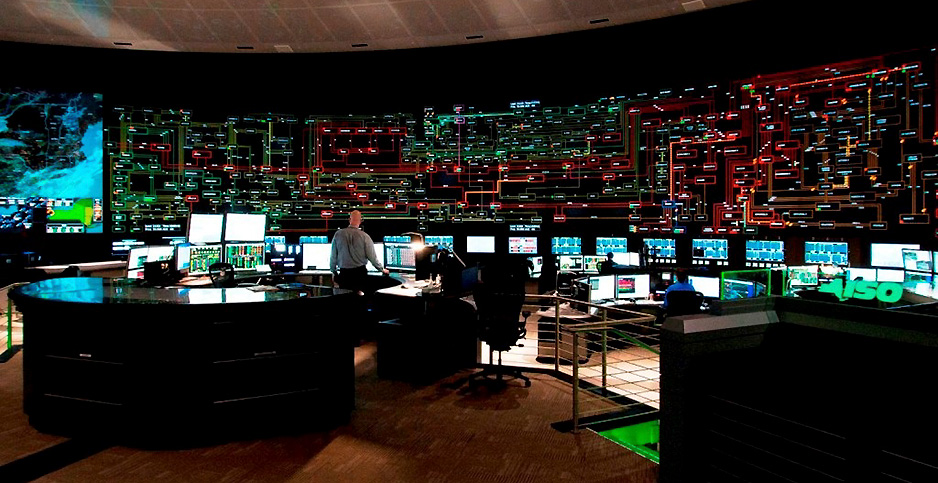

In [194]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

# added some formatting for EDA
plt.rcParams['figure.figsize'] = (18, 6)
plt.rcParams['font.size'] = 11
%matplotlib inline

%config InlineBackend.figure_format = 'retina'

plt.style.use('fivethirtyeight')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [195]:
# Obtain monthly consumption and cost data by borough and development. Data set includes utility vendor and meter information.
#https://data.cityofnewyork.us/Housing-Development/Electric-Consumption-And-Cost-2010-April-2020-/jr24-e7cr
df = pd.read_csv("./data/Electric_Consumption.csv")

In [196]:
df['Datetime']=pd.to_datetime(df['Service End Date'], infer_datetime_format=True)  

In [197]:
df['month'] = df['Datetime'].dt.month

In [198]:
#Add NYC Temperature and precipitation averages to the dataframe.
# 2019 NYC Temperature averages can be found here: https://www.weather.gov/media/okx/Climate/CentralPark/monthlyannualtemp.pdf
# 2019 NYC Precipation averages can be found here: https://www.weather.gov/media/okx/Climate/CentralPark/monthlyannualprecip.pdf

monthly_avg_temps = {1.0: 32.5, 2.0: 36.2, 3.0: 41.7, 4.0: 55.5, 5.0: 62.2, 6.0: 71.7, 7.0: 79.6, 8.0: 75.5, 9.0: 70.4, 10.0: 59.9, 11.0: 38.3, 12.0: 38.3}
monthly_avg_rainfall = {1.0: 3.58, 2.0: 3.14, 3.0: 3.87, 4.0: 4.55, 5.0: 6.82, 6.0: 5.46, 7.0: 5.77, 8.0: 3.70, 9.0: 0.95, 10.0: 6.15, 11.0: 1.95, 12.0: 7.09}

In [199]:
df['monthly_avg_temps'] = df['month'].map(monthly_avg_temps)
df['monthly_rainfall_avg'] = df['month'].map(monthly_avg_rainfall)
df['average_monthly_consumption'] = (df['Consumption (KW)']/df['# days'])*30

In [200]:
df.dtypes

Development Name                       object
Borough                                object
Account Name                           object
Location                               object
Meter AMR                              object
Meter Scope                            object
TDS #                                 float64
EDP                                     int64
RC Code                                object
Funding Source                         object
AMP #                                  object
Vendor Name                            object
UMIS BILL ID                            int64
Revenue Month                          object
Service Start Date                     object
Service End Date                       object
# days                                float64
Meter Number                           object
Estimated                              object
Current Charges                        object
Rate Class                             object
Bill Analyzed                     

In [201]:
df.head()

,Development Name,Borough,Account Name,Location,Meter AMR,Meter Scope,TDS #,EDP,RC Code,Funding Source,AMP #,Vendor Name,UMIS BILL ID,Revenue Month,Service Start Date,Service End Date,# days,Meter Number,Estimated,Current Charges,Rate Class,Bill Analyzed,Consumption (KWH),KWH Charges,Consumption (KW),KW Charges,Other charges,Datetime,month,monthly_avg_temps,monthly_rainfall_avg,average_monthly_consumption
0,ADAMS,BRONX,ADAMS,BLD 05,NONE,BLD 01 to 07,118.0,248,B011800,FEDERAL,NY005001180P,NEW YORK POWER AUTHORITY,7531827,2019-01,12/24/2018,1/24/2019,31.0,7223256,N,"16,427.30",GOV/NYC/068,Yes,126400.0,"4,796.88",216.0,"2,021.76","9,608.66",2019-01-24,1.0,32.5,3.58,209.032258
1,ADAMS,BRONX,ADAMS,BLD 05,NONE,BLD 01 to 07,118.0,248,B011800,FEDERAL,NY005001180P,NEW YORK POWER AUTHORITY,7707509,2019-02,1/24/2019,2/25/2019,32.0,7223256,Y,"13,796.86",GOV/NYC/068,Exception,121600.0,"4,614.72",200.0,"1,872","7,310.14",2019-02-25,2.0,36.2,3.14,187.500000
2,ADAMS,BRONX,ADAMS,BLD 05,NONE,BLD 01 to 07,118.0,248,B011800,FEDERAL,NY005001180P,NEW YORK POWER AUTHORITY,7707904,2019-03,2/25/2019,3/26/2019,29.0,7223256,N,"18,631.53",GOV/NYC/068,Exception,110400.0,"4,189.68",200.0,"1,872","12,569.85",2019-03-26,3.0,41.7,3.87,206.896552
3,ADAMS,BRONX,ADAMS,BLD 05,NONE,BLD 01 to 07,118.0,248,B011800,FEDERAL,NY005001180P,NEW YORK POWER AUTHORITY,7793830,2019-04,3/26/2019,4/24/2019,29.0,7223256,N,"12,460.49",GOV/NYC/068,Exception,104000.0,"3,946.80",192.0,"1,797.12","6,716.57",2019-04-24,4.0,55.5,4.55,198.620690
4,ADAMS,BRONX,ADAMS,BLD 05,NONE,BLD 01 to 07,118.0,248,B011800,FEDERAL,NY005001180P,NEW YORK POWER AUTHORITY,7875598,2019-05,4/24/2019,5/23/2019,29.0,7223256,N,"14,575.68",GOV/NYC/068,Yes,100000.0,"3,795",200.0,"1,872","8,908.68",2019-05-23,5.0,62.2,6.82,206.896552


In [250]:
df = df[df['Consumption (KW)'] < 2500]

In [251]:
df = df.sort_values(by=['month'])


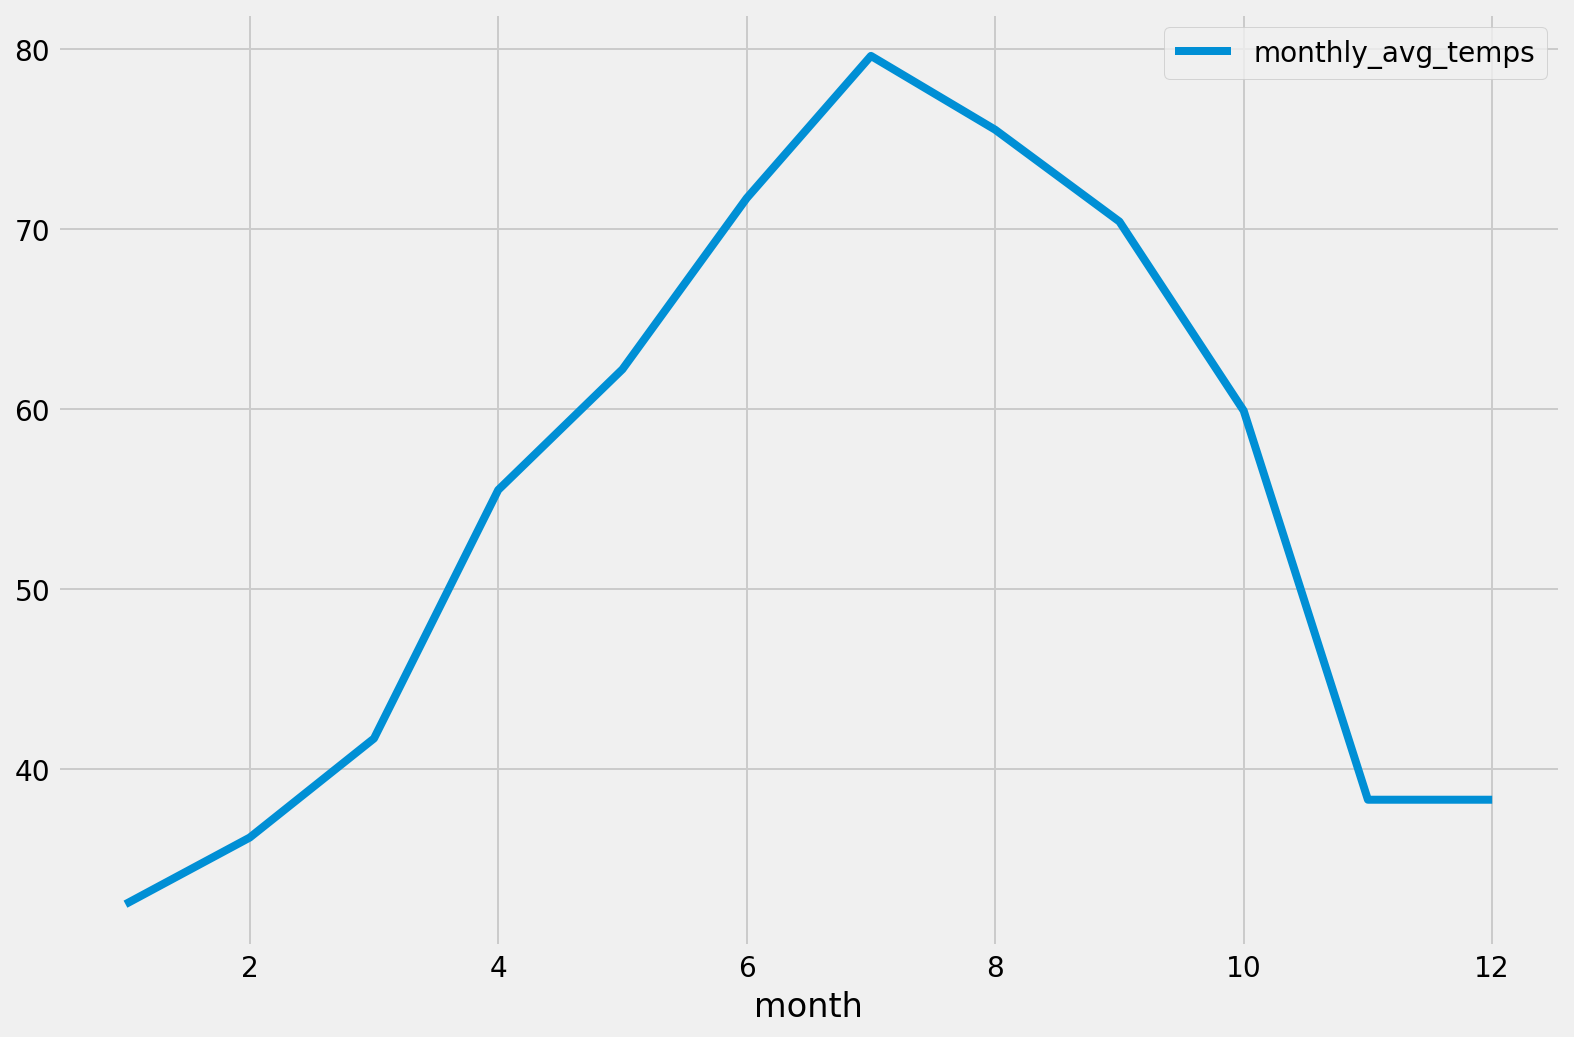

In [252]:
df.plot(kind='line', x='month', y='monthly_avg_temps');

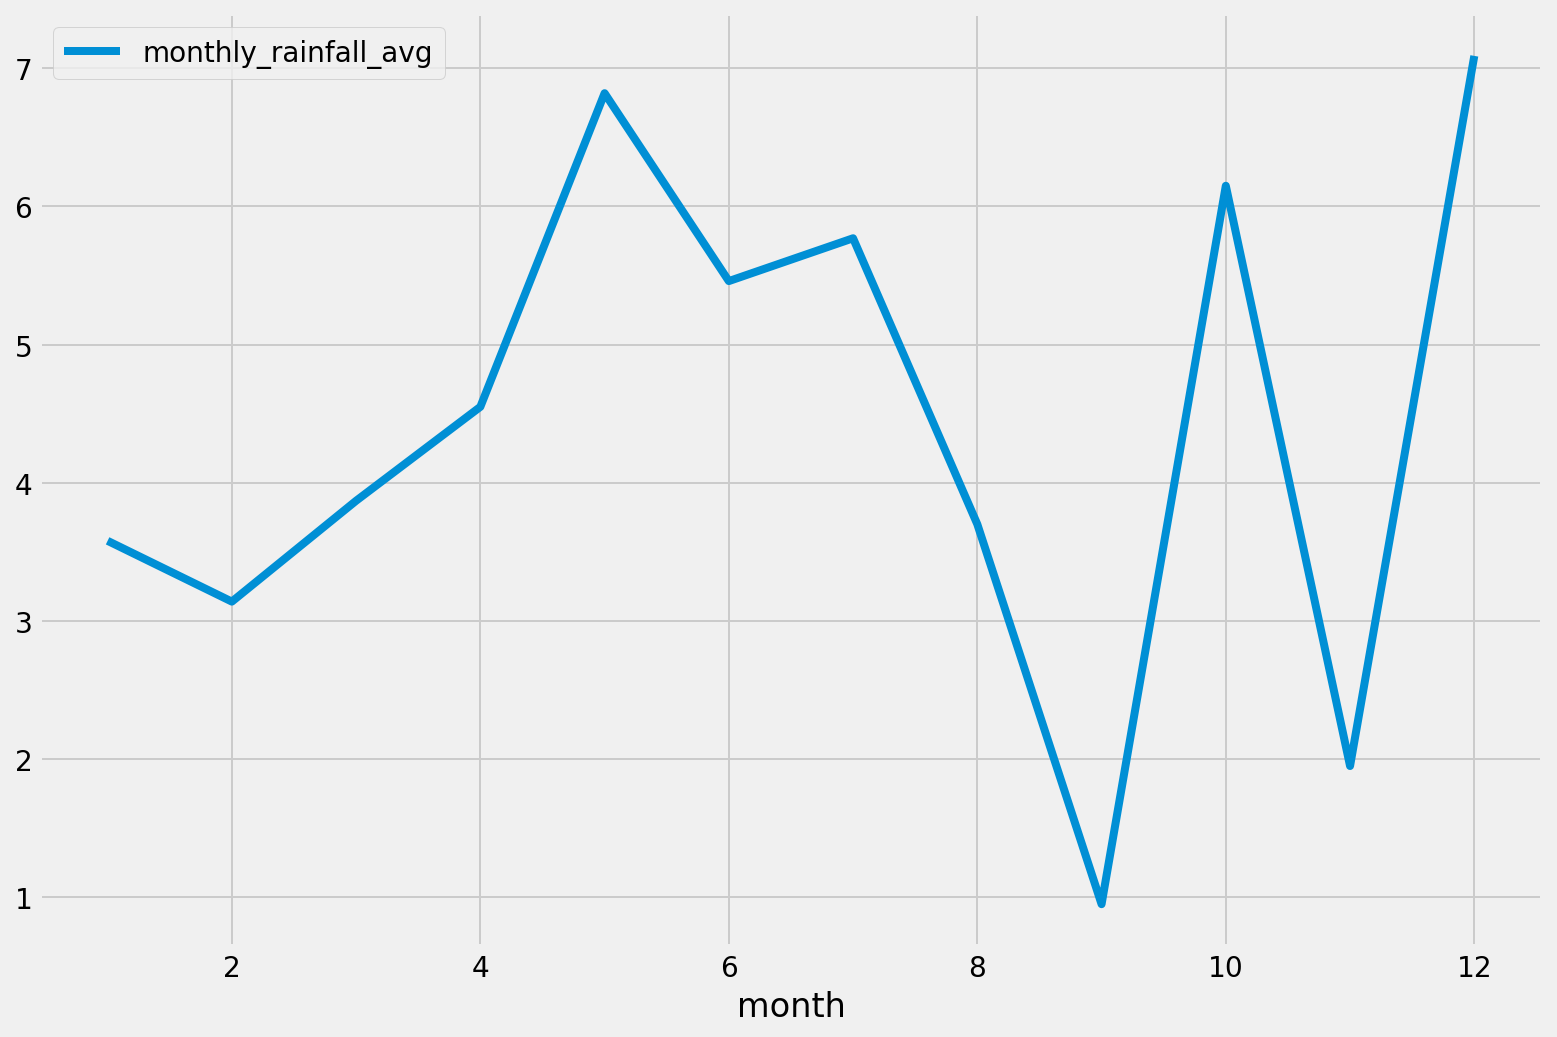

In [253]:
df.plot(kind='line', x='month', y='monthly_rainfall_avg');

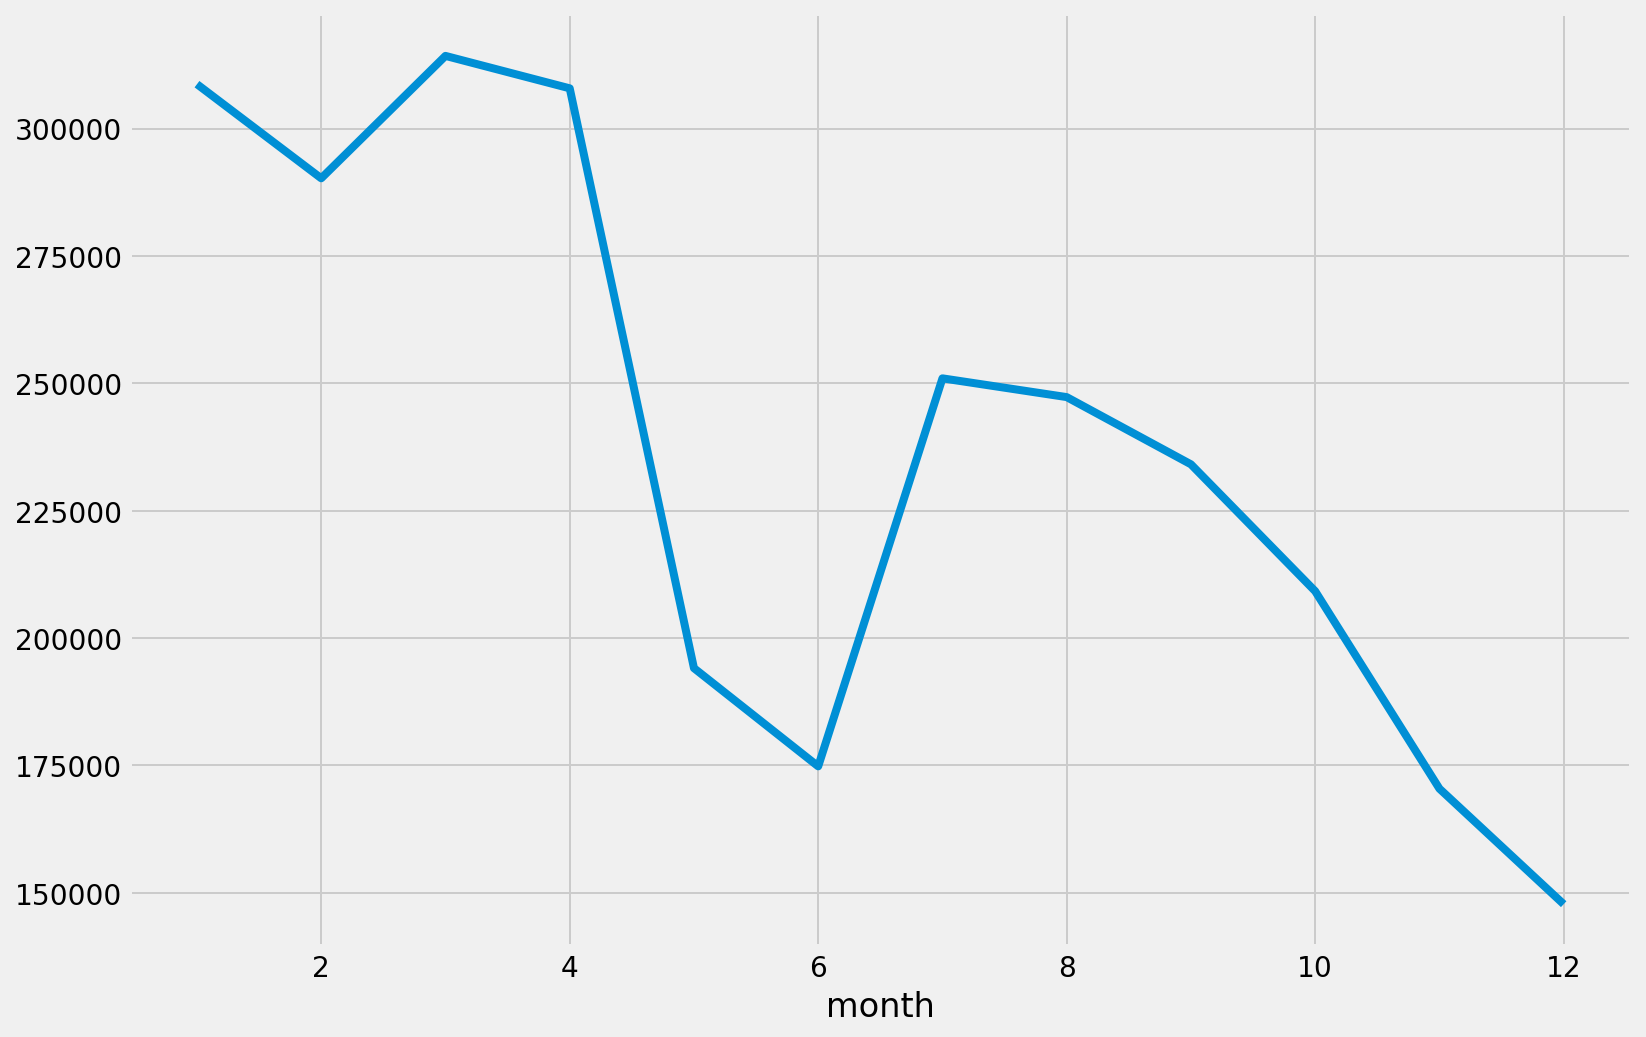

In [257]:
df.groupby(['month'])['average_monthly_consumption'].sum().plot()

In [206]:
df_2 = df[['Development Name', 'Borough', 'Meter Number', 'Consumption (KW)', '# days', 'KW Charges', 'month', 'monthly_avg_temps', 'monthly_rainfall_avg']]

In [207]:
df_2.shape

(52274, 9)

In [209]:
df_2.isnull().sum()

Development Name        248
Borough                   0
Meter Number              0
Consumption (KW)          0
# days                    3
KW Charges                0
month                     3
monthly_avg_temps         3
monthly_rainfall_avg      3
dtype: int64

In [210]:
#Review null month, monthly avg temps and rainfall.
df_2[df_2['month'].isnull()]


,Development Name,Borough,Meter Number,Consumption (KW),# days,KW Charges,month,monthly_avg_temps,monthly_rainfall_avg
31413,LOWER EAST SIDE II,MANHATTAN,5503302,0.0,NaN,0,NaN,NaN,NaN
34281,RED HOOK EAST,BROOKLYN,9956008,0.0,NaN,0,NaN,NaN,NaN
34284,RED HOOK EAST,BROOKLYN,9956007,0.0,NaN,0,NaN,NaN,NaN


In [211]:
df_2 = df_2.drop(df_2.index[[31413,34281,34284]])

In [212]:
#Replace null development names with other
df_2.loc[df_2['Development Name'].isnull(),'Development Name'] = 'Other'

In [213]:
df_2.dtypes

Development Name         object
Borough                  object
Meter Number             object
Consumption (KW)        float64
# days                  float64
KW Charges               object
month                   float64
monthly_avg_temps       float64
monthly_rainfall_avg    float64
dtype: object

In [214]:
df['Consumption (KW)'] = pd.to_numeric(df['Consumption (KW)'], downcast="float")

In [215]:
df_2.describe()

,Consumption (KW),# days,month,monthly_avg_temps,monthly_rainfall_avg
count,52271.000000,52268.000000,52268.000000,52268.000000,52268.000000
mean,63.128325,30.373460,5.539738,51.552214,4.245942
std,1528.691176,2.020709,3.531969,15.885775,1.641573
min,0.000000,1.000000,1.000000,32.500000,0.950000
25%,0.000000,29.000000,3.000000,38.300000,3.140000
50%,16.320000,30.000000,5.000000,41.700000,3.870000
75%,79.250000,32.000000,9.000000,62.200000,5.770000
max,329074.000000,257.000000,12.000000,79.600000,7.090000


In [216]:
#Created a column called is_peak to identify the months (June, July, August) that are peak electricity usage.
df_2['is_peak']=(df_2['month']<8.5) & (df_2['month']>5.5)

In [217]:
#Because the monthly billing cycle varies from customer to customer, a good measure is to calculate the daily energy consumption.
df_2['daily_consumption'] = pd.to_numeric(df_2['Consumption (KW)'], errors = 'coerce')/df_2['# days']

In [218]:
df_2.head()

,Development Name,Borough,Meter Number,Consumption (KW),# days,KW Charges,month,monthly_avg_temps,monthly_rainfall_avg,is_peak,daily_consumption
0,ADAMS,BRONX,7223256,216.00,31.0,"2,021.76",1.0,32.5,3.58,False,6.967742
29675,GRANT,MANHATTAN,1142960,193.32,31.0,"2,124.14",1.0,32.5,3.58,False,6.236129
29674,GRANT,MANHATTAN,1142959,189.12,31.0,"2,078",1.0,32.5,3.58,False,6.100645
8999,GOMPERS,MANHATTAN,8809153,144.00,31.0,"1,124.64",1.0,32.5,3.58,False,4.645161
29673,GRANT,MANHATTAN,1142958,169.92,31.0,"1,867.03",1.0,32.5,3.58,False,5.481290


In [219]:
df_3=df_2.groupby(['Meter Number', 'is_peak']).agg({'monthly_avg_temps':'mean', 'monthly_rainfall_avg':'mean', 'daily_consumption':'mean','Borough':'first', 'Development Name':'first'} )

In [220]:
df_3 = df_3.unstack()

In [221]:
df_3.head()

monthly_avg_temps       monthly_rainfall_avg            \
is_peak                  False True                 False     True    
Meter Number                                                          
1000059              43.233333   NaN             4.000000       NaN   
1008347              46.223077  75.6             4.095385  4.976667   
1008348              46.600000   NaN             3.910000       NaN   
1008779              46.223077  75.6             4.095385  4.976667   
1008789              46.223077  75.6             4.095385  4.976667   

             daily_consumption                              Borough         \
is_peak                  False      True                      False  True    
Meter Number                                                                 
1000059               1.272931        NaN                     BRONX    NaN   
1008347               1.910603   3.068801                     BRONX  BRONX   
1008348               7.769502        NaN  NON DEVELOPMENT FACILITY    NaN   
1008779               5.010512   7.825221                     BRONX  BRONX   
1008789               7.852491  10.179374                     BRONX  BRONX   

                               Development Name                       
is_peak                                   False                True   
Meter Number                                                          
1000059       CLAREMONT PARKWAY-FRANKLIN AVENUE                  NaN  
1008347                     EASTCHESTER GARDENS  EASTCHESTER GARDENS  
1008348                                   Other                  NaN  
1008779                       SAINT MARY'S PARK    SAINT MARY'S PARK  
1008789                       SAINT MARY'S PARK    SAINT MARY'S PARK

In [222]:
df_3.columns.values

array([('monthly_avg_temps', False), ('monthly_avg_temps', True),
       ('monthly_rainfall_avg', False), ('monthly_rainfall_avg', True),
       ('daily_consumption', False), ('daily_consumption', True),
       ('Borough', False), ('Borough', True), ('Development Name', False),
       ('Development Name', True)], dtype=object)

In [223]:
def clean_col(x):
    if x[1]:
        s2 = '_peak'
    else:
        s2 = '_nonpeak'
    return x[0] + s2

In [224]:
df_3.columns.values

array([('monthly_avg_temps', False), ('monthly_avg_temps', True),
       ('monthly_rainfall_avg', False), ('monthly_rainfall_avg', True),
       ('daily_consumption', False), ('daily_consumption', True),
       ('Borough', False), ('Borough', True), ('Development Name', False),
       ('Development Name', True)], dtype=object)

In [225]:
df_3.columns = [clean_col(col) for col in df_3.columns]

In [226]:
df_3.columns.values

array(['monthly_avg_temps_nonpeak', 'monthly_avg_temps_peak',
       'monthly_rainfall_avg_nonpeak', 'monthly_rainfall_avg_peak',
       'daily_consumption_nonpeak', 'daily_consumption_peak',
       'Borough_nonpeak', 'Borough_peak', 'Development Name_nonpeak',
       'Development Name_peak'], dtype=object)

In [227]:
df_3.head()

,monthly_avg_temps_nonpeak,monthly_avg_temps_peak,monthly_rainfall_avg_nonpeak,monthly_rainfall_avg_peak,daily_consumption_nonpeak,daily_consumption_peak,Borough_nonpeak,Borough_peak,Development Name_nonpeak,Development Name_peak
Meter Number,,,,,,,,,,
1000059,43.233333,NaN,4.000000,NaN,1.272931,NaN,BRONX,NaN,CLAREMONT PARKWAY-FRANKLIN AVENUE,NaN
1008347,46.223077,75.6,4.095385,4.976667,1.910603,3.068801,BRONX,BRONX,EASTCHESTER GARDENS,EASTCHESTER GARDENS
1008348,46.600000,NaN,3.910000,NaN,7.769502,NaN,NON DEVELOPMENT FACILITY,NaN,Other,NaN
1008779,46.223077,75.6,4.095385,4.976667,5.010512,7.825221,BRONX,BRONX,SAINT MARY'S PARK,SAINT MARY'S PARK
1008789,46.223077,75.6,4.095385,4.976667,7.852491,10.179374,BRONX,BRONX,SAINT MARY'S PARK,SAINT MARY'S PARK


In [228]:
df_3.isnull().sum()

monthly_avg_temps_nonpeak         0
monthly_avg_temps_peak          640
monthly_rainfall_avg_nonpeak      0
monthly_rainfall_avg_peak       640
daily_consumption_nonpeak         0
daily_consumption_peak          640
Borough_nonpeak                   0
Borough_peak                    640
Development Name_nonpeak          0
Development Name_peak           640
dtype: int64

In [229]:
df_3 = df_3.dropna()

In [230]:
df_3=df_3.drop(['Borough_peak', 'Development Name_peak'], axis=1)

In [231]:
df_3 = df_3.rename(columns={"Borough_nonpeak": "Borough", "Development Name_nonpeak": "Development"})

In [232]:
df_3['peak_to_nonpeak_ratio'] = df_3['daily_consumption_peak']/df_3['daily_consumption_nonpeak']

In [233]:
df_3.shape

(3176, 9)

In [234]:
df_3.head()

,monthly_avg_temps_nonpeak,monthly_avg_temps_peak,monthly_rainfall_avg_nonpeak,monthly_rainfall_avg_peak,daily_consumption_nonpeak,daily_consumption_peak,Borough,Development,peak_to_nonpeak_ratio
Meter Number,,,,,,,,,
1008347,46.223077,75.6,4.095385,4.976667,1.910603,3.068801,BRONX,EASTCHESTER GARDENS,1.606196
1008779,46.223077,75.6,4.095385,4.976667,5.010512,7.825221,BRONX,SAINT MARY'S PARK,1.561761
1008789,46.223077,75.6,4.095385,4.976667,7.852491,10.179374,BRONX,SAINT MARY'S PARK,1.296324
1008845,46.223077,75.6,4.095385,4.976667,14.363671,20.902253,MANHATTAN,CHELSEA,1.455217
1008856,46.223077,75.6,4.095385,4.976667,14.971758,23.014184,STATEN ISLAND,TODT HILL,1.537173


In [235]:
df_3[(df_3['peak_to_nonpeak_ratio'] > 0.1) & (df_3['peak_to_nonpeak_ratio'] <500)]

,monthly_avg_temps_nonpeak,monthly_avg_temps_peak,monthly_rainfall_avg_nonpeak,monthly_rainfall_avg_peak,daily_consumption_nonpeak,daily_consumption_peak,Borough,Development,peak_to_nonpeak_ratio
Meter Number,,,,,,,,,
1008347,46.223077,75.60,4.095385,4.976667,1.910603,3.068801,BRONX,EASTCHESTER GARDENS,1.606196
1008779,46.223077,75.60,4.095385,4.976667,5.010512,7.825221,BRONX,SAINT MARY'S PARK,1.561761
1008789,46.223077,75.60,4.095385,4.976667,7.852491,10.179374,BRONX,SAINT MARY'S PARK,1.296324
1008845,46.223077,75.60,4.095385,4.976667,14.363671,20.902253,MANHATTAN,CHELSEA,1.455217
1008856,46.223077,75.60,4.095385,4.976667,14.971758,23.014184,STATEN ISLAND,TODT HILL,1.537173
1008857,46.223077,75.60,4.095385,4.976667,14.953617,22.673402,STATEN ISLAND,SOUTH BEACH,1.516249
1008858,46.223077,75.60,4.095385,4.976667,15.974433,24.654333,STATEN ISLAND,BERRY,1.543362
1008955,46.223077,75.60,4.095385,4.976667,1.824877,2.812908,BRONX,PELHAM PARKWAY,1.541423
1008964,46.223077,75.60,4.095385,4.976667,2.075461,3.327492,BRONX,PELHAM PARKWAY,1.603254


In [236]:
df_3.drop(['1860113_1600-87.8%', '1096662-58.5'], inplace=True)

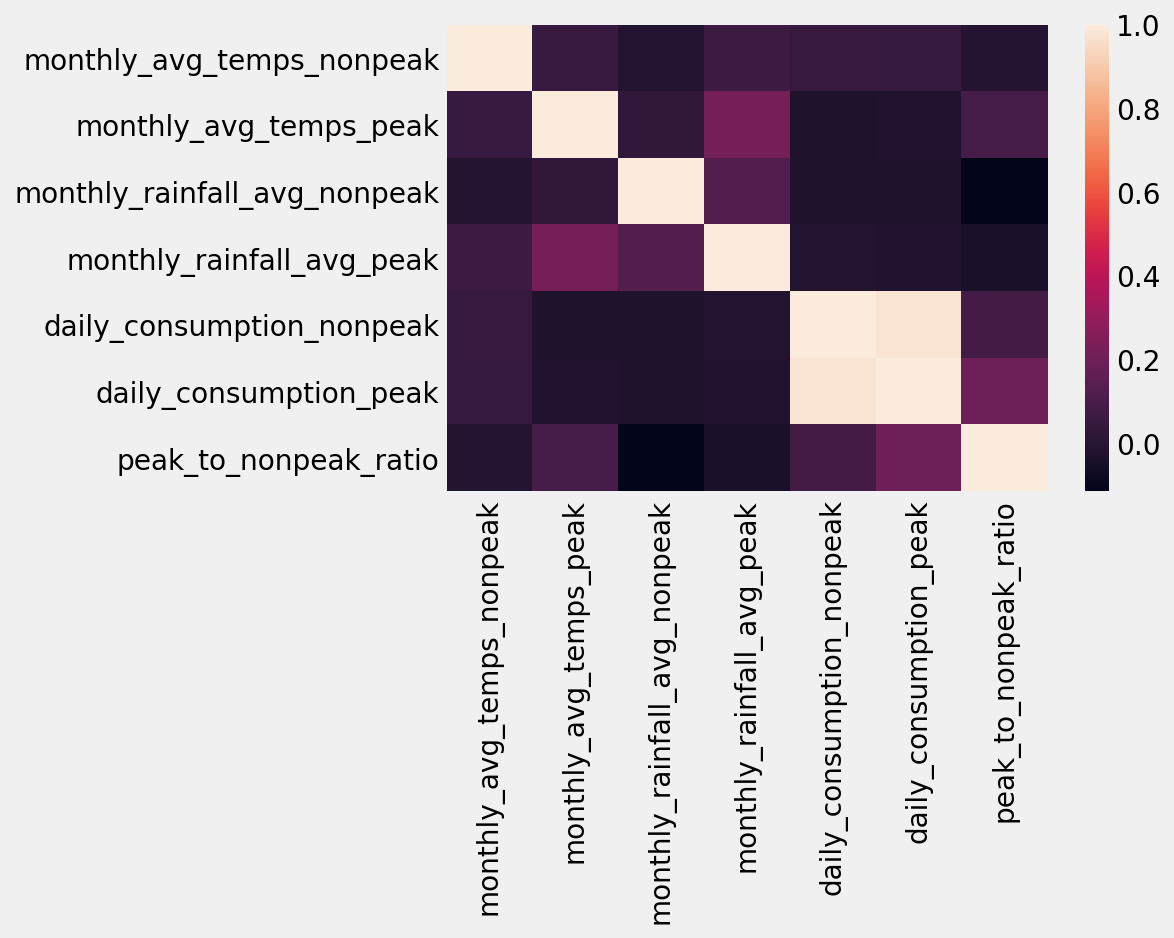

In [237]:
sns.heatmap(df_3.corr())

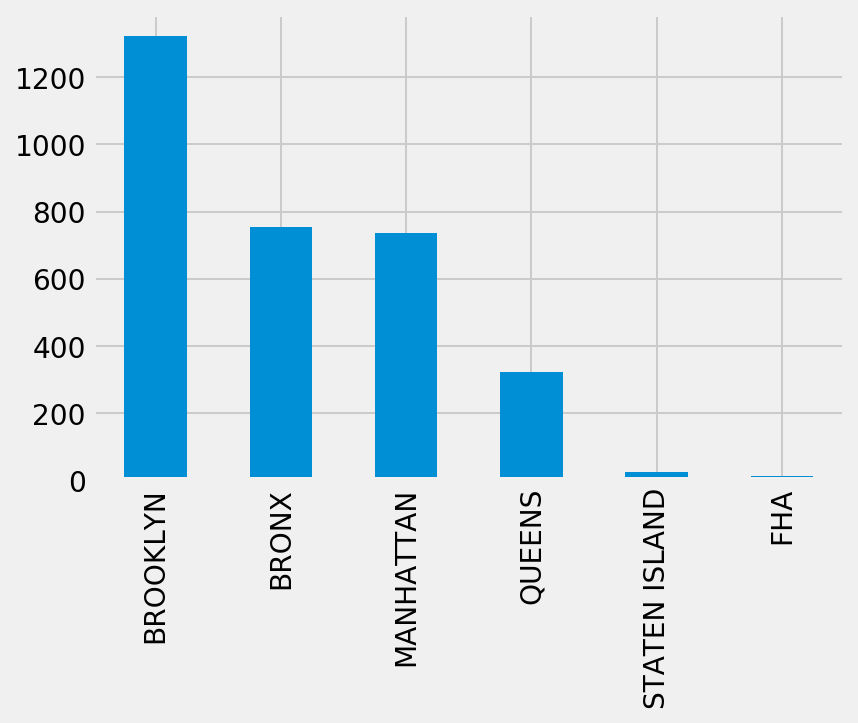

In [238]:
df_3['Borough'].value_counts().plot(kind ='bar')
# Number of total customer from each borough
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 14

In [239]:
#Number of customers in each development by area
df_3.groupby('Borough')['Development'].value_counts()

Borough        Development                                 
BRONX          EDENWALD                                        68
               THROGGS NECK                                    58
               SOTOMAYOR HOUSES                                57
               PELHAM PARKWAY                                  47
               FOREST                                          30
               PATTERSON                                       30
               PARKSIDE                                        24
               SOUNDVIEW                                       23
               MARBLE HILL                                     22
               EASTCHESTER GARDENS                             20
               BRONX RIVER                                     19
               MILL BROOK                                      18
               MELROSE                                         17
               CASTLE HILL                                     15
               S

C:\Users\Arief\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


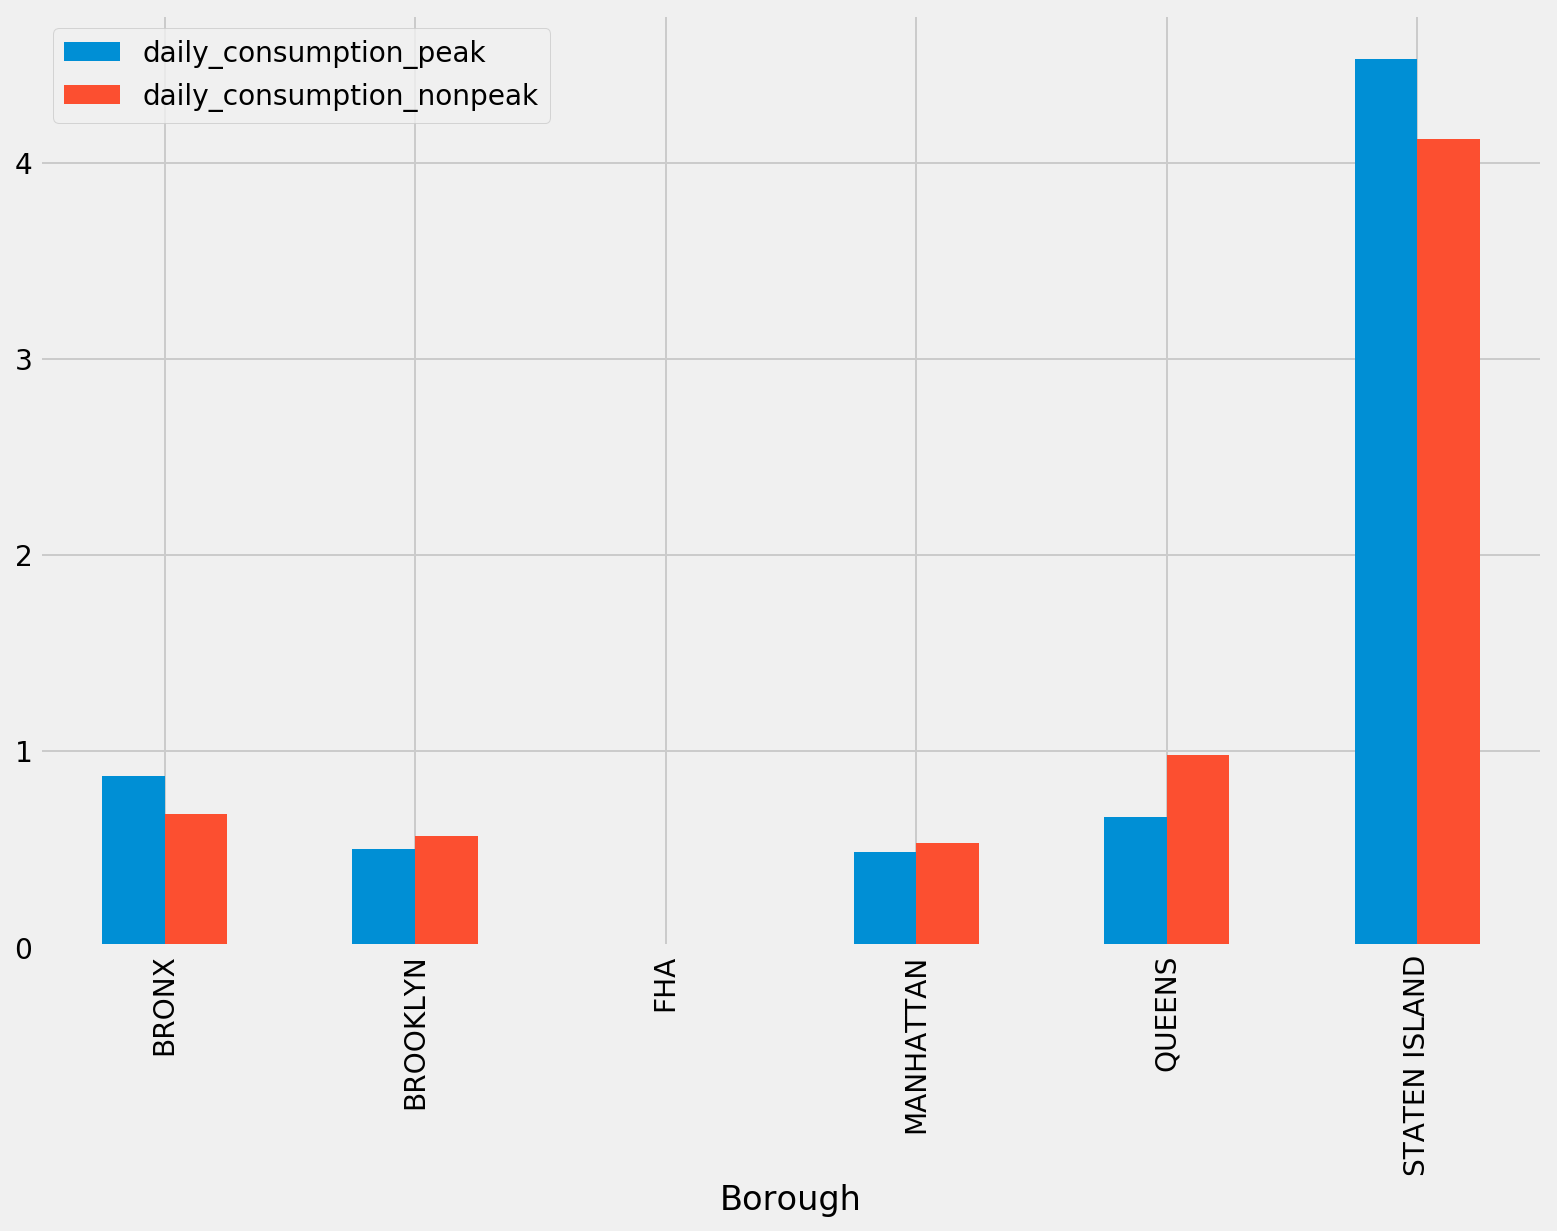

In [240]:
df_3.groupby('Borough')['daily_consumption_peak', 'daily_consumption_nonpeak'].median().plot(kind='bar');

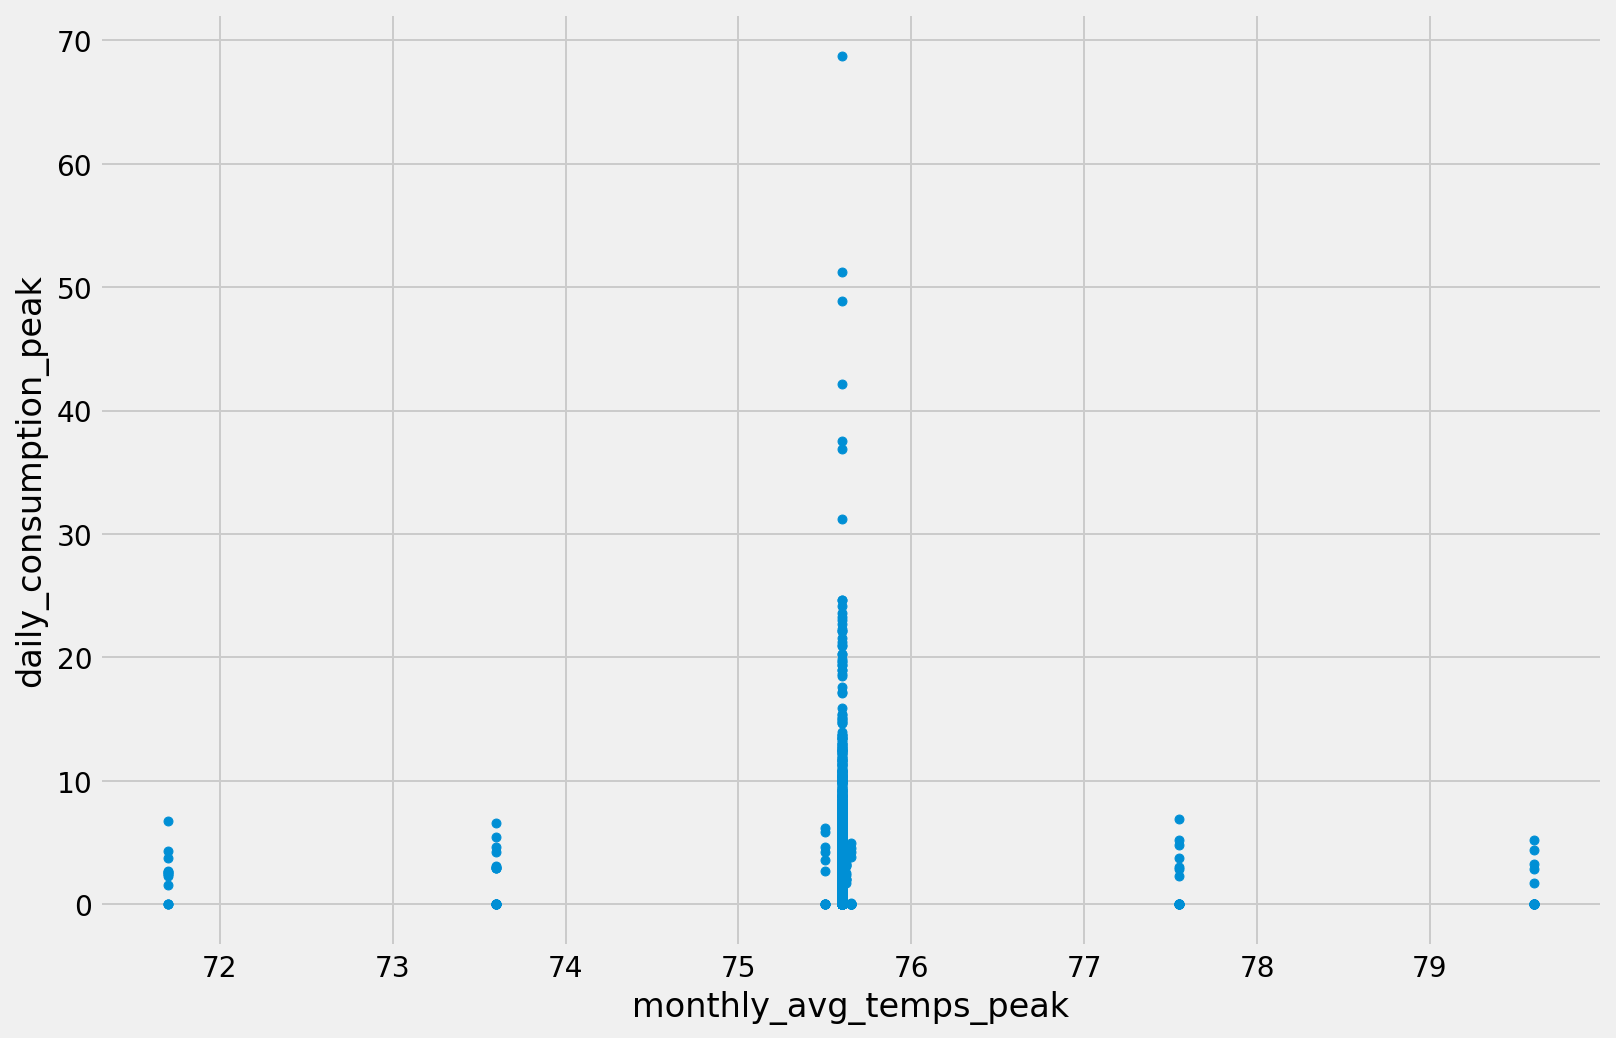

In [241]:
df_3.plot(kind='scatter', x='monthly_avg_temps_peak', y='daily_consumption_peak');

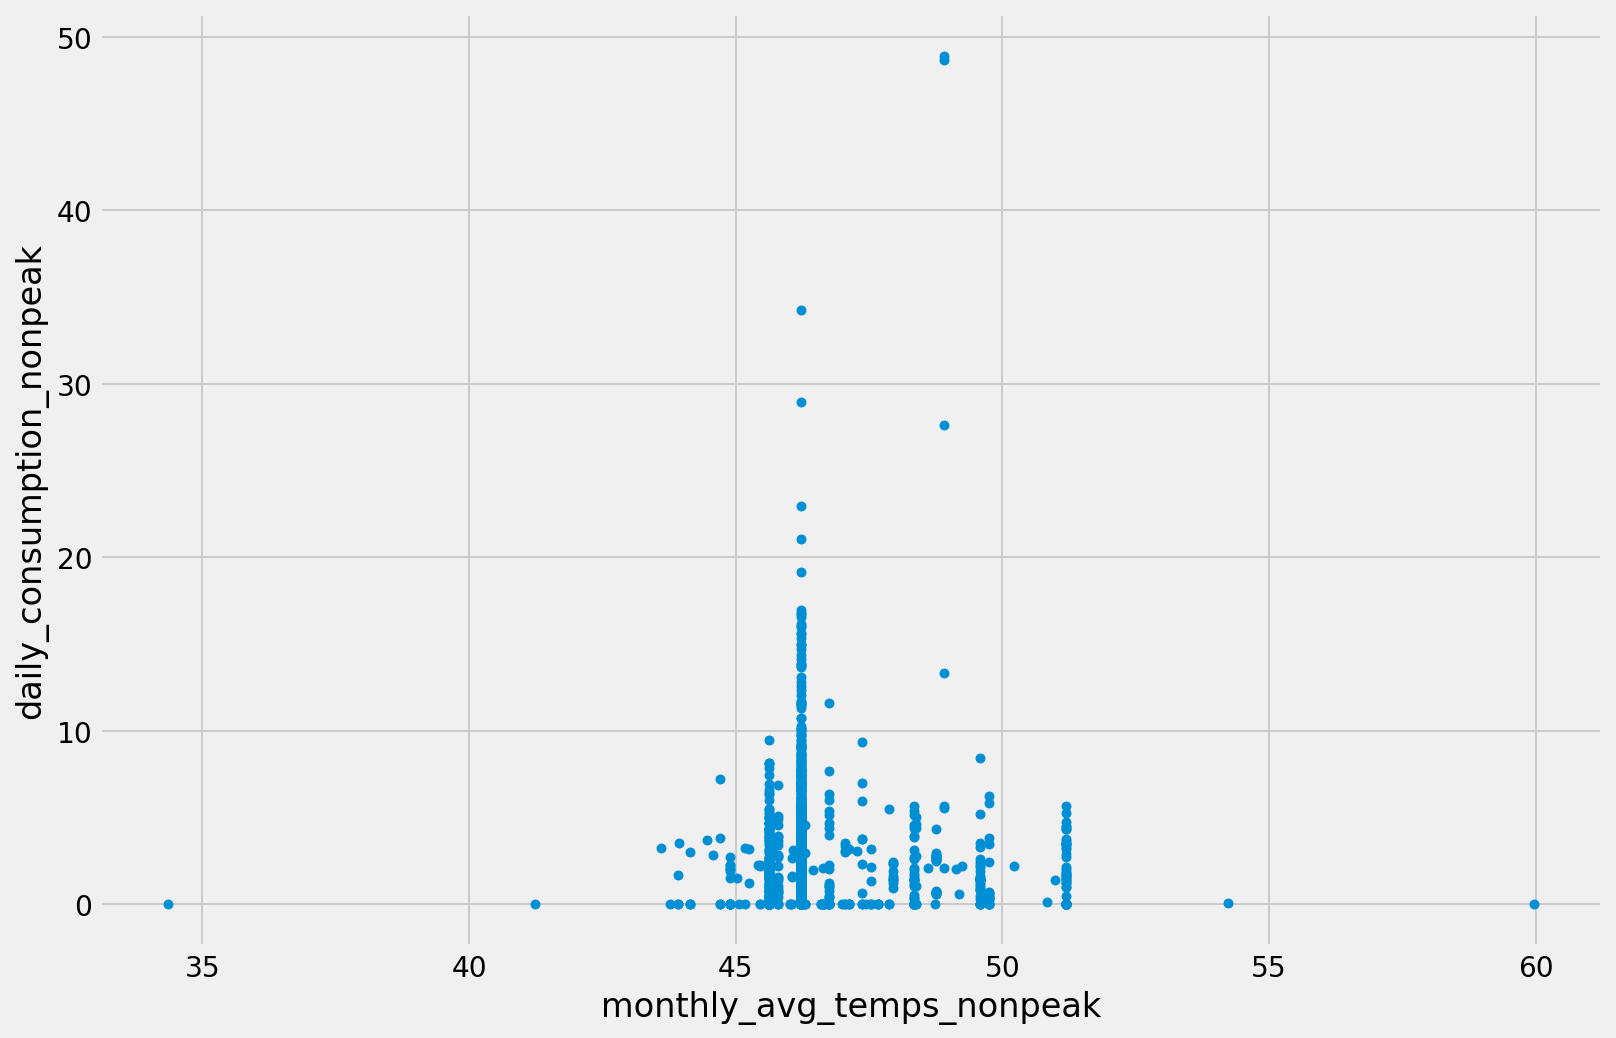

In [242]:
df_3.plot(kind='scatter', x='monthly_avg_temps_nonpeak', y='daily_consumption_nonpeak');

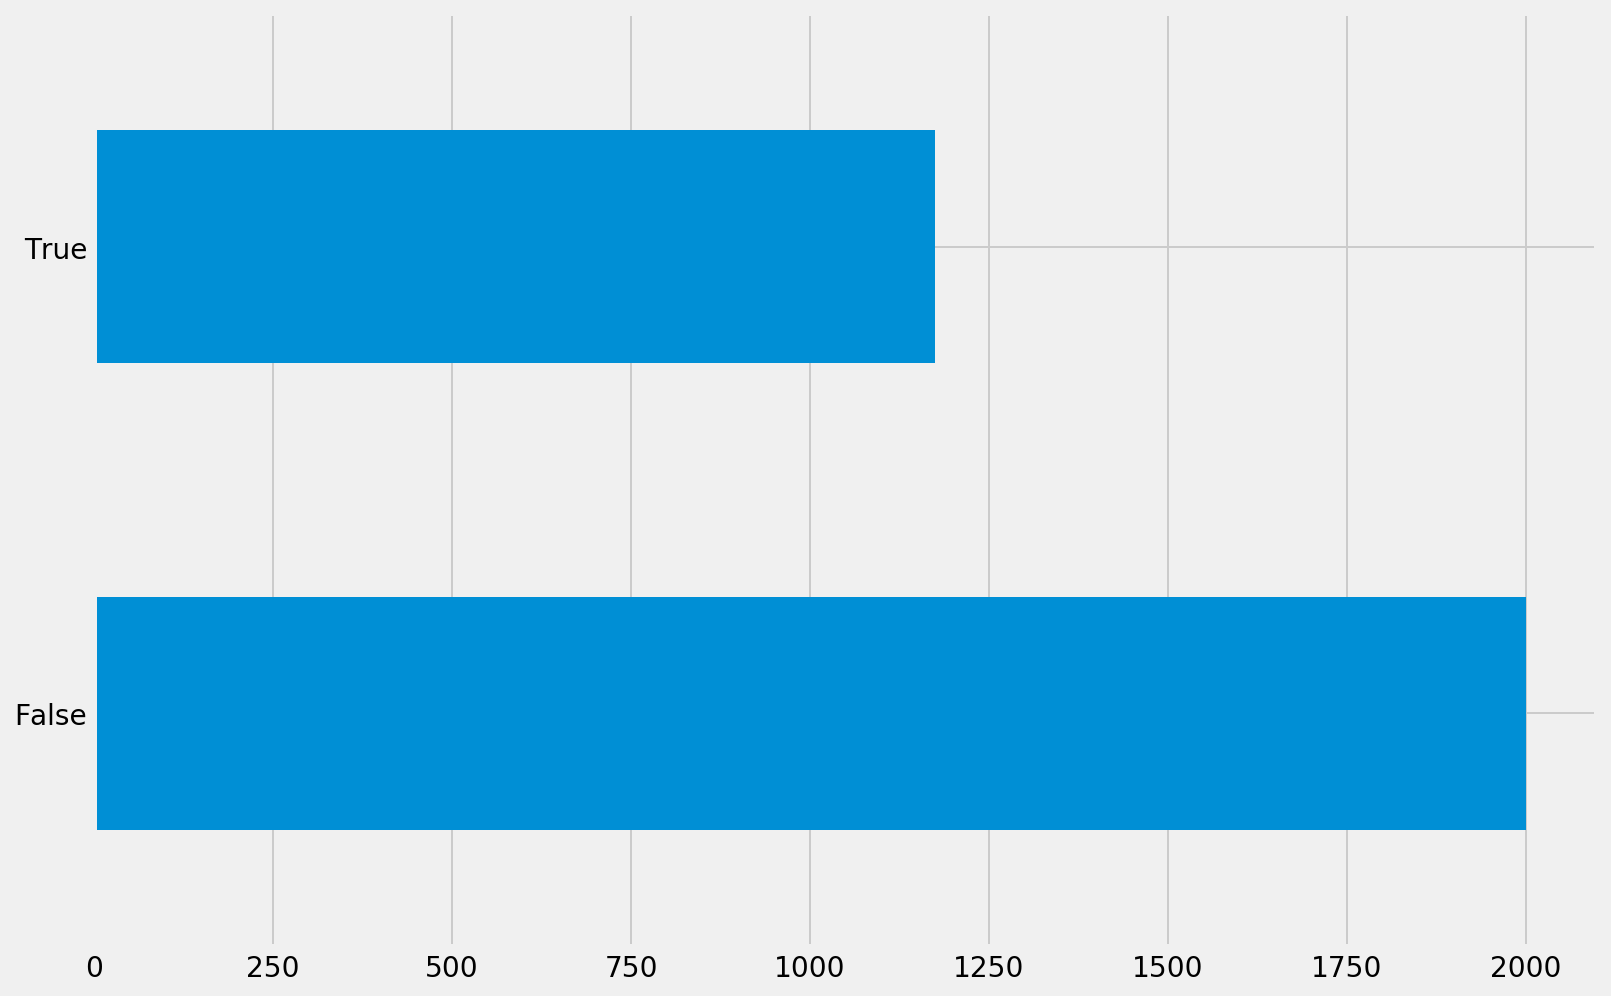

In [243]:
#At least 1174 customers were eligible for the program in 2019 based on a 35% usage increase
(df_3['peak_to_nonpeak_ratio'] > 1.35).value_counts().plot(kind = 'barh')